<h2>JPEG</h2>
This code exemplifies some of the steps used to encode JPGE images (block DCT and quantization)

In [10]:
%matplotlib inline
import cv2
import io
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack
import matplotlib.image as mpimg

<h3>Entropy<h3>

In [11]:
# image entropy
def calcEntropy(img):
    hist = cv2.calcHist([img],[0],None,[256],[0,256])
    hist = hist.ravel()/hist.sum() #probabilidade de ocorrência do pixel (p(i))
    logs = np.log2(hist+0.00001)
    entropy = -1 * (hist*logs).sum()

    return entropy

<h3>Huffman<h3>

In [12]:
from heapq import heappush, heappop, heapify
from collections import defaultdict

def encode(symb2freq):
    heap = [[wt, [sym, ""]] for sym, wt in symb2freq.items()]
    heapify(heap)
    while len(heap) > 1:
        lo = heappop(heap)
        hi = heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])
    return sorted(heappop(heap)[1:], key=lambda p: (len(p[-1]), p))

<h3>Ordenação Zig-Zag<h3>

In [13]:
def zigzag(matrix):
    linhas, cols = matrix.shape
    matrix = np.array(matrix)
    resultado = [[] for _ in range(linhas + cols - 1)]
    for i in range(linhas):
        for j in range(cols):
            sum_idx = i + j
            if sum_idx % 2 == 0:
                resultado[sum_idx].insert(0, matrix[i][j])
            else:
                resultado[sum_idx].append(matrix[i][j])
    # Garantir que a saída seja uma lista linear
    return [item for lista in resultado for item in lista]

def inverso_zigzag(zigzagged, linhas, cols):
    resultado = np.zeros((linhas, cols))
    index = 0
    for i in range(linhas + cols - 1):
        if i % 2 == 0:
            for j in range(max(0, i - cols + 1), min(i + 1, linhas)):
                resultado[j, i - j] = zigzagged[index]
                index += 1
        else:
            for j in range(max(0, i - cols + 1), min(i + 1, linhas)):
                resultado[i - j, j] = zigzagged[index]
                index += 1
    return resultado

<h3>DCT<h3>

In [14]:
# funções auxiliares
def get_2D_dct(img):
    """ Get 2D Cosine Transform of Image
    """
    return fftpack.dct(fftpack.dct(img.T, norm='ortho').T, norm='ortho')

def get_2d_idct(coefficients):
    """ Get 2D Inverse Cosine Transform of Image
    """
    return fftpack.idct(fftpack.idct(coefficients.T, norm='ortho').T, norm='ortho')

def get_reconstructed_image(raw):
    img = raw.clip(0, 255)
    img = img.astype('uint8')
    img = Image.fromarray(img)
    return img

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


def psnr(predictions, targets):
    rmsev = rmse(predictions, targets)
    return 20 * np.log10(255/rmsev)

<h3>Codificação por Entropia<h3>

In [15]:
def entropy_encoding(quantized_blocks, output_file):
    from collections import defaultdict

    # ordenação em zigue-zague para todos os blocos
    zigzagged = []
    for block in quantized_blocks:
        zigzagged.extend(zigzag(block))

    # calcular a frequência dos símbolos
    symb2freq = defaultdict(int)
    for symbol in zigzagged:
        symb2freq[symbol] += 1

    # codificar usando huffman
    huffman_encoded = encode(symb2freq)
    huffman_dict = {p[0]: p[1] for p in huffman_encoded}

    encoded_data = "".join(huffman_dict[symbol] for symbol in zigzagged)

    # salvar os dados codificados e o dicionário de huffman no disco
    with open(output_file, "w") as f:
        for symbol, code in huffman_dict.items(): #mapa de huffman
            f.write(f"{symbol}: {code}\n")
        f.write("===\n")
        f.write(encoded_data) #os dados codificados

def entropy_decoding(encoded_file, QM, size, step):
    with open(encoded_file, "r") as f:
        lines = f.readlines()
    
    huffman_dict = {}
    encoded_data = ""
    separator_found = False

    for line in lines:
        if line.strip() == "===":
            separator_found = True
            continue
        if not separator_found:
            symbol, code = line.strip().split(": ")
            huffman_dict[code] = int(symbol)
        else:
            encoded_data += line.strip()
    
    # decodificar os dados
    decoded_symbols = []
    buffer = ""
    for bit in encoded_data:
        buffer += bit
        if buffer in huffman_dict:
            decoded_symbols.append(huffman_dict[buffer])
            buffer = ""
    
    # reverter a ordenação em zigue-zague e reconstruir os blocos
    quantized_blocks = []
    for i in range(0, len(decoded_symbols), step * step):
        block = decoded_symbols[i:i + step * step]
        block = inverso_zigzag(block, step, step)
        quantized_blocks.append(block)
    
    # reverter a quantização e reconstruir a imagem
    reconstructed_image = np.zeros(size, dtype=float)
    idx = 0
    for y in range(0, size[0], step):
        for x in range(0, size[1], step):
            block = quantized_blocks[idx]
            block = np.multiply(block, QM)
            reconstructed_image[y:y+step, x:x+step] = get_2d_idct(block)
            idx += 1
    
    return reconstructed_image + 128  # reverter o deslocamento

<h3>Fourier<h3>

In [16]:
img = cv2.imread('lena512.pgm',0)
f = np.fft.fft2(img) #fft2 returns the 2D fourier transform
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

Entropia : 7.44

Patch after DCT:
[[-327.75   -67.632  -19.507   -5.221    4.5      1.922    3.209    1.588]
 [ -84.677  -18.749    0.484   -3.446    2.369   -4.467   -3.287    4.002]
 [ -10.366    0.798   13.48    -3.958    8.747    6.865    1.055   -2.194]
 [  -8.972    1.699    0.932    1.137    0.425    4.757    2.217   -1.557]
 [  -6.5      6.031    1.752   -0.501   -1.25     2.652   -0.996   -3.117]
 [  -4.147    4.574    1.97    -1.253    0.838    0.555   -0.429   -1.904]
 [  -8.695   -3.441   -4.945    2.11     1.518   -4.112    2.52     2.46 ]
 [   2.747   -2.009   -0.988    1.571    3.825   -3.964    1.77     2.057]]

Patch to be coded:
[[-20  -6  -2   0   0   0   0   0]
 [ -7  -2   0   0   0   0   0   0]
 [ -1   0   1   0   0   0   0   0]
 [ -1   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]]

Reconstructed patch:
[[-20  -6  -2   0   0   0   0   0]
 [ -7  

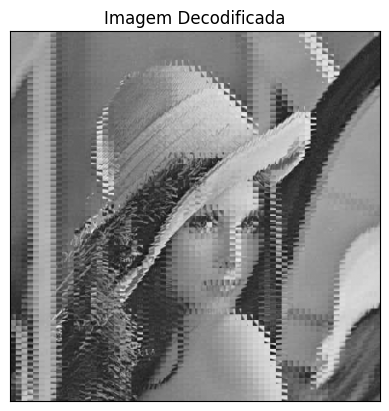

In [17]:
# aplicação da tabela de quantização
img = cv2.imread('lena512.pgm',0) # codificação em escala de cinza
print(f"Entropia : {calcEntropy(img):.2f}")
img = img.astype(float)
step = 8 

size = img.shape
IDCT = np.zeros(size, dtype=float)
DCT = np.zeros(size, dtype=float)
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

QM = np.matrix([[16, 11, 10, 16, 24, 40, 51, 61], 
                [12, 12, 14, 19, 26, 58, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

QM = QM.astype(float)

dc_coefficients = []
quantized_blocks = []
img = img-128
for y in range(0,size[0],step):
    for x in range(0,size[1],step):
        dct = get_2D_dct(img[y:y+step, x:x+step])
        odct = dct #pega só a dct de um bloco bloco 8x8, nao um conjunto todo
        dc_coefficients.append(dct[0, 0])
        
        dct = np.divide(dct, QM)
        dct = dct.round()
        dct = dct.astype(int)
        coddct = dct
        quantized_blocks.append(dct)

             
print ("\nPatch after DCT:"  )      
print (odct)

print ("\nPatch to be coded:")
print (coddct)

print ("\nReconstructed patch:") #pos quantização
print (dct)     

output_file = "encoded_image.txt"
entropy_encoding(quantized_blocks, output_file)

decoded_image = entropy_decoding("encoded_image.txt", QM, size, step)

img = img + 128

print ("RMSE: %5.3f" % rmse(img, decoded_image))
print ("PSNR: %5.3f" % psnr(img, decoded_image))

# Exibir a imagem reconstruída
plt.imshow(decoded_image, cmap="gray", clim=(0, 255))
plt.title("Imagem Decodificada")
plt.xticks([]), plt.yticks([])
plt.show()


#file with decoded JPEG
mpimg.imsave("imagem_reconstruida.png", decoded_image, 0, 255, cmap='gray')